In [123]:
# import modules

In [124]:
from pandas import DataFrame

In [125]:
from pandas import Series

In [126]:
from pandas import concat

In [127]:
from pandas import read_csv

In [128]:
from datetime import datetime

In [129]:
from sklearn.metrics import mean_squared_error

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
import tensorflow

In [132]:
from keras.models import Sequential

In [133]:
from keras.layers import Dense

In [134]:
from keras.layers import LSTM

In [135]:
from math import sqrt

In [136]:
from matplotlib import pyplot

In [137]:
import numpy

1) Test RMSE: 154.425
2) Test RMSE: 113.294
3) Test RMSE: 143.640
4) Test RMSE: 129.165
5) Test RMSE: 125.258
6) Test RMSE: 106.446
7) Test RMSE: 102.277
8) Test RMSE: 191.799
9) Test RMSE: 174.663
10) Test RMSE: 95.274
11) Test RMSE: 358.786
12) Test RMSE: 116.592
13) Test RMSE: 98.788
14) Test RMSE: 164.143
15) Test RMSE: 92.695
16) Test RMSE: 117.941
17) Test RMSE: 137.919
18) Test RMSE: 110.290
19) Test RMSE: 221.828
20) Test RMSE: 113.554
21) Test RMSE: 144.515
22) Test RMSE: 100.966
23) Test RMSE: 146.310
24) Test RMSE: 91.012
25) Test RMSE: 110.110
26) Test RMSE: 112.878
27) Test RMSE: 206.760
28) Test RMSE: 119.376
29) Test RMSE: 119.194
30) Test RMSE: 120.506
             rmse
count   30.000000
mean   138.013437
std     53.367836
min     91.012290
25%    110.154794
50%    119.284988
75%    145.861358
max    358.785646


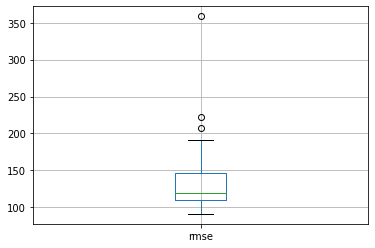

In [138]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)
 
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()